# Convolutional Neural Network Binary Classfication


#### Intro to binary CNN
https://towardsdatascience.com/10-minutes-to-building-a-cnn-binary-image-classifier-in-tensorflow-4e216b2034aa

#### Code Inspiration from here..

https://medium.com/techiepedia/binary-image-classifier-cnn-using-tensorflow-a3f5d6746697 


In [1]:
# Libraries that might be installed beforehand

#!pip install opencv-python
#!pip install sklearn

In [46]:
# Default Libraries
import pandas as pd
import tensorflow as tf
import numpy as np

# CNN Envrionment
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

# Plotting Libraries
import matplotlib.pyplot as plt

# Miscellaneous
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import os
import shutil
import cv2
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Python Scripts
#import sys  
#sys.path.insert(0, './Python_Scripts')

In [3]:
# Check for Tensorflow version
print(tf.__version__)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)

2.7.0


In [4]:
# Load Data
df = pd.read_csv('Data/train_complete.csv')
df.head(2)

,FilePath,ImageId,ClassId,EncodedPixels,Defect
0,/Users/michael/neuefische/CapstoneProject_Stee...,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,1
1,/Users/michael/neuefische/CapstoneProject_Stee...,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...,1


## Test Split and Data Storage Preparation

In [5]:
 # Do the test split
X = df.iloc[:,0:4]
y = df.iloc[:,4]

# Split into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state = 1)

print('Length of Train-Set: ' + str(len(y_train)))
print('Length of Test-Set: ' + str(len(y_test)))

Length of Train-Set: 9097
Length of Test-Set: 3900


In [6]:
# Check No-Defect Distributions
print('No-Defect-Ratio in Train: ' + str(round((y_train == 0).astype(int).sum(axis=0) / len(y_train),4)))
print('No-Defect-Ratio in Test: ' + str(round((y_test == 0).astype(int).sum(axis=0) / len(y_test),4)))

No-Defect-Ratio in Train: 0.4541
No-Defect-Ratio in Test: 0.4541


In [8]:
# Create a temp path for the train & test split
def MakePathStructure():
    path = os.getcwd()
    #
    ## You might need to adjust the path to your local environment
    temp_path = path + "/Data/Temp"
    
    # Make DirectoryTemp and Sub-Directories Train & Test
    try:
        os.mkdir(temp_path)
        os.mkdir(temp_path + '/Train')
        os.mkdir(temp_path + '/Test')
        os.mkdir(temp_path + '/Train/C0')
        os.mkdir(temp_path + '/Train/C1')
        os.mkdir(temp_path + '/Test/C0')
        os.mkdir(temp_path + '/Test/C1')
    
        
    except OSError:
        return print ("Creation of the directories failed")
    else:
        return print ("Successfully created the directories")

In [9]:
# Execute Function If Test-Temp Folder Structure is not ready yet..

#MakePathStructure()

Creation of the directories failed


In [8]:
# Copy and Separate in Imgages in Test and Train Folder
def CopySeparateImagesToTestTrain():
# Train Data
    for i in range(len(X_train)):
        origin_train_path = path + '/Data/train_images/'
        source_file = X_train.iloc[i,1]
        
        #Seperate the classes into subfolders C0 and C1
        if y_train.iloc[i] == 0:
            target_directory = path + '/Data/Temp/Train/C0/'
        else:
            target_directory = path + '/Data/Temp/Train/C1/'
        # Copy The Files
        shutil.copy2(origin_train_path + source_file , target_directory + source_file)
        
    # Test Data
    for i in range(len(X_test)):
        origin_train_path = path + '/Data/train_images/'
        source_file = X_test.iloc[i,1]
        
        #Seperate the classes into subfolders C0 and C1
        if y_train.iloc[i] == 0:
            target_directory = path + '/Data/Temp/Test/C0/'
        else:
            target_directory = path + '/Data/Temp/Test/C1/'
        # Copy The Files
        shutil.copy2(origin_train_path + source_file , target_directory + source_file)

In [ ]:
# Execute function if files needs to copied into the subfolders und splitted into the classes

#CopySeparateImagesToTestTrain()

## CNN Model Preparation

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

https://keras.io/api/preprocessing/image/

In [9]:
# Optional Setting
#tf.keras.preprocessing.image_dataset_from_directory(
#    './Data/Temp',
#    labels="inferred",
#    label_mode="int",
#    class_names=None,
#    color_mode="rgb",
#    batch_size=32,
#    image_size=(256, 1600),
#    shuffle=True,
#    seed=None,
#    validation_split=None,
#    subset=None,
#    interpolation="bilinear",
#    follow_links=False,
#    crop_to_aspect_ratio=False,
#)

Found 12769 files belonging to 2 classes.
Metal device set to: Apple M1


2022-02-06 14:52:06.182067: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-06 14:52:06.182455: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<BatchDataset shapes: ((None, 256, 1600, 3), (None,)), types: (tf.float32, tf.int32)>

In [25]:
# Get current working directory
path = os.getcwd()

# Normalize the color values between 0 and 1
train = ImageDataGenerator(rescale=1/255)
validation = ImageDataGenerator(rescale=1/255)

# Takes the path to a directory & generates batches of augmented data.
train_generator = train.flow_from_directory( path + '/Data/Temp/Train/',
                                          target_size=(256,1600),   #150,150
                                          batch_size = 32,
                                          class_mode = 'binary')

# Takes the path to a directory & generates batches of augmented data.
validation_generator = validation.flow_from_directory(path + '/Data/Temp/Test/',
                                          target_size=(256,1600),
                                          batch_size = 32,
                                          class_mode = 'binary')

Found 8885 images belonging to 2 classes.
Found 3884 images belonging to 2 classes.


In [26]:
print('Data labels are separated in following binary code: ' + str(test_dataset.class_indices))

Data labels are separated in following binary code: {'C0': 0, 'C1': 1}


https://keras.io/guides/sequential_model/

In [27]:
model = keras.Sequential()

# Convolutional layer and maxpool layer 1, 32 filters and 3x3 Kernel
model.add(keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(256,1600,3)))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 2
model.add(keras.layers.Conv2D(32,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 3
model.add(keras.layers.Conv2D(64,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 4
model.add(keras.layers.Conv2D(64,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 5
model.add(keras.layers.Conv2D(64,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# This layer flattens the resulting image array to 1D array
model.add(keras.layers.Flatten())

# Hidden layer with XXX neurons and Rectified Linear Unit activation function 
model.add(keras.layers.Dense(512,activation='relu'))


# Output layer with single neuron which gives 0 for Non-Failure or 1 for Failure 
#Here we use sigmoid activation function which makes our model output to lie between 0 and 1
model.add(keras.layers.Dense(1,activation='sigmoid'))

In [28]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 254, 1598, 16)     448       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 127, 799, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 125, 797, 32)      4640      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 62, 398, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 60, 396, 64)       18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 30, 198, 64)     

https://keras.io/api/models/model_training_apis/

In [49]:
opt = tf.keras.optimizers.RMSprop()
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/

## CNN Model Fitting Process

In [50]:
#steps_per_epoch = train_imagesize/batch_size

history = model.fit(train_dataset,
          steps_per_epoch = 10,
          epochs = 3,
          verbose=1,
          validation_data = validation_generator,
          validation_steps=8) 

Epoch 1/3


2022-02-06 15:53:49.511260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 0.8626 - accuracy: 0.5906

2022-02-06 15:53:58.825459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 12s 1s/step - loss: 0.8626 - accuracy: 0.5906 - val_loss: 0.6958 - val_accuracy: 0.5508
Epoch 2/3
10/10 [==============================] - 11s 1s/step - loss: 0.6688 - accuracy: 0.5750 - val_loss: 0.7085 - val_accuracy: 0.5273
Epoch 3/3
10/10 [==============================] - 11s 1s/step - loss: 0.6697 - accuracy: 0.5563 - val_loss: 0.7346 - val_accuracy: 0.5508


## CNN Evaluate Model Preformance

In [51]:
# Evaluate The Model Accuracy
model.evaluate(validation_generator)

122/122 [==============================] - 28s 227ms/step - loss: 0.7332 - accuracy: 0.5458


[0.7331998944282532, 0.5458290576934814]

In [53]:
# Delete the validation generator
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()
preds = model.predict(validation_generator,
verbose=1)

122/122 [==============================] - 27s 223ms/step


## Visualize the Performance 

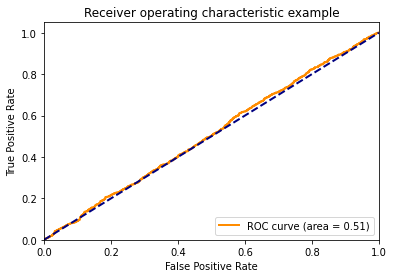

In [54]:

fpr, tpr, _ = roc_curve(validation_generator.classes, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [43]:
def predictImage(filename):
    img1 = image.load_img(filename,target_size=(256,1600))
    
    plt.imshow(img1)
 
    Y = image.img_to_array(img1)
    
    X = np.expand_dims(Y,axis=0)
    val = model.predict(X)
    print(val)
    if val == 1:
        
        plt.xlabel("Non-Failure",fontsize=30)
         
    elif val == 0:  
        plt.xlabel("Failure",fontsize=30)

[[2.574389e-13]]


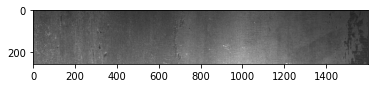

In [44]:
predictImage(path + '/Data/train_images/0002cc93b.jpg')